In [2]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm_notebook
np.set_printoptions(suppress=True)
from sklearn import preprocessing
from tqdm import tqdm
import decimal
from itertools import combinations
from random import shuffle
from time import sleep
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
import gc
import datetime
from sklearn.model_selection import train_test_split, KFold, GroupKFold
import os
from sklearn.metrics import roc_auc_score
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
import random
import lightgbm as lgb

In [2]:
#Always seed the randomness of this universe
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
seed_everything(seed=51)

In [4]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)

In [5]:
train_dtypes = pd.read_csv('../input/train8_dtypes.csv')
test_dtypes = pd.read_csv('../input/test8_dtypes.csv')
train_dtypes.index = train_dtypes['TransactionID']
del train_dtypes['TransactionID']
test_dtypes.index = test_dtypes['TransactionID']
del test_dtypes['TransactionID']
train_dtypes = train_dtypes.iloc[:,0]
test_dtypes = test_dtypes.iloc[:,0]
print(type(train_dtypes),type(test_dtypes))
train_dtypes = train_dtypes.to_dict()
test_dtypes = test_dtypes.to_dict()
gc.collect()

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


21

In [6]:
%%time
train = pd.read_csv('../input/train8.csv',dtype= train_dtypes)
print("train finished")

train finished
CPU times: user 2min 25s, sys: 4.57 s, total: 2min 29s
Wall time: 2min 31s


In [7]:
%%time
test = pd.read_csv('../input/test8.csv',dtype= test_dtypes)
print("test finished")

test finished
CPU times: user 2min 7s, sys: 3.37 s, total: 2min 10s
Wall time: 2min 12s


In [8]:
#sample_submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
print(train.shape,test.shape,sample_submission.shape)

(590540, 1923) (506691, 1922) (506691, 2)


In [3]:
importances= pd.read_csv('../importances/importances16.csv')

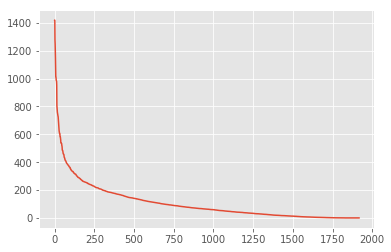

In [5]:
importances['avg'].plot(kind='line')

In [6]:
importances.head(250)

,index,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5,avg
0,C13,1617,1368,1569,1361,1181,1419.2
1,D15,1610,1395,1533,1397,1154,1417.8
2,D4,1431,1287,1370,1164,1141,1278.6
3,hour,1546,1202,1434,1024,1043,1249.8
4,C1,1367,1209,1271,1102,1046,1199.0
5,D2,1297,1089,1220,1141,987,1146.8
6,card1,1134,1057,1158,1005,883,1047.4
7,TransactionAmt_decimal,1194,981,1079,944,861,1011.8
8,D1,1139,958,1099,954,906,1011.2
9,D10,1144,922,1053,982,863,992.8


# Train data is subsampled

In [ ]:
train_0 = train[train['isFraud'] == 0].sample(frac = 0.2)
train_1 = train[train['isFraud'] == 1]
del train
gc.collect()
print(train_0.shape,train_1.shape)
train = pd.concat([train_0,train_1],axis=0)
train = train.sample(frac=1.0)
train = train.reset_index(drop=True)
print(train.shape,test.shape)
del train_0,train_1
gc.collect()

# Training

In [ ]:
train.drop(['TransactionID','TransactionDT','dayofyear','day'],axis=1,inplace=True)
test.drop(['TransactionID','TransactionDT','dayofyear','day'],axis=1,inplace=True)
gc.collect()

In [ ]:
y = train['isFraud']
del train['isFraud']

In [ ]:
########################### Model params
lgb_params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.04,
                    'num_leaves': 2**8,
                    'max_depth':12,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':500,
                    'max_bin':255,
                    'verbose':-1,
                    'seed': 51,
                    'early_stopping_rounds':100, 
                } 

In [ ]:
N = 5
kf = KFold(n_splits=N)

importance = pd.DataFrame(np.zeros((train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=train.columns)
scores = []
y_pred = np.zeros(test.shape[0])
oof = np.zeros(train.shape[0])

for fold, (trn_idx, val_idx) in enumerate(kf.split(train, y), 1):
    print('Fold {}'.format(fold))
          
    trn_data = lgb.Dataset(train.iloc[trn_idx, :].values, label=y.iloc[trn_idx].values)
    val_data = lgb.Dataset(train.iloc[val_idx, :].values, label=y.iloc[val_idx].values)   
    
    clf = lgb.train(lgb_params, trn_data ,valid_sets=[trn_data, val_data], verbose_eval=100)

    predictions = clf.predict(train.iloc[val_idx, :].values) 
    importance.iloc[:, fold - 1] = clf.feature_importance()
    oof[val_idx] = predictions

    score = roc_auc_score(y.iloc[val_idx].values, predictions)
    scores.append(score)
    print('Fold {} ROC AUC Score {}\n'.format(fold, score))

    y_pred += clf.predict(test) / N
    
    del trn_data, val_data, predictions
    gc.collect()
    
print('Average ROC AUC Score {} [STD:{}]'.format(np.mean(scores), np.std(scores)))

In [ ]:
print(roc_auc_score(y,oof))

In [ ]:
importance['avg'] = importance.mean(axis=1)

In [ ]:
importance = importance.sort_values(by='avg',ascending=False)

In [ ]:
importance = importance.reset_index(drop=False)

In [ ]:
importance.head()

In [ ]:
importance.to_csv('../importances/importances16.csv',index=False)

In [ ]:
sample_submission.head()

In [ ]:
sample_submission['isFraud'] = y_pred

In [ ]:
sample_submission.head()

In [ ]:
plt.hist(sample_submission['isFraud'],bins=200)
plt.show()

In [ ]:
sample_submission.to_csv('../predictions/pred16.csv',index=False)

In [ ]:
!kaggle competitions submit -c ieee-fraud-detection -f ../predictions/pred16.csv -m "pred16"